# Hands-on demo for XCNET

In this notebook we showcase how to use the pre-trained model that we provide to perform exemplar-based colourisation.

## Preliminaries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

from models.xcnet import xcnet
from data.utils import lab2rgb, rgb2lab

import warnings
warnings.filterwarnings("ignore")

In [2]:
shape = 224  # pre-trained models only support square shape of 224 pixels
device = torch.device("cuda:1")

In [3]:
_toTensor = transforms.ToTensor()
_centerCrop = transforms.CenterCrop(shape)
_resize = transforms.Resize(shape)
_toPIL = transforms.ToPILImage()

def _rgb2lab(img, device):
    return rgb2lab(img.unsqueeze(0), device)[0]

def _lab2rgb(img, device):
    img_t = torch.clamp(lab2rgb(img, device), 0, 1)[0].detach().cpu()
    return _toPIL(img_t).convert("RGB")

def load_img(name, device):
    img = Image.open(name)
    size = img.size
    if size[0] != size[1]:
        img = _centerCrop(img)
    img = _resize(img)
    return img, _rgb2lab(_toTensor(img), device).unsqueeze(0)

## Load pre-trained ECNET

In [4]:
model = xcnet(pretrained=True).to(device).eval()

## Prediction

Read target and reference images and prepare inputs

In [5]:
tgt, tgt_t = load_img("img/target_1.png", device)
ref, ref_t = load_img("img/reference_1.png", device)

tgt_t = tgt_t.to(device)
ref_t = ref_t.to(device)

luma_input = tgt_t[:, [0], :, :]
tgt_input = torch.cat((luma_input, luma_input, luma_input), dim=1)

Predict colour channels and concatenate with the luma input to get the colour prediction

In [6]:
with torch.no_grad():
    pred_t = model(tgt_input, ref_t)[0]
    pred_t = torch.cat((luma_input, pred_t), 1)

Process output and visualise predictions

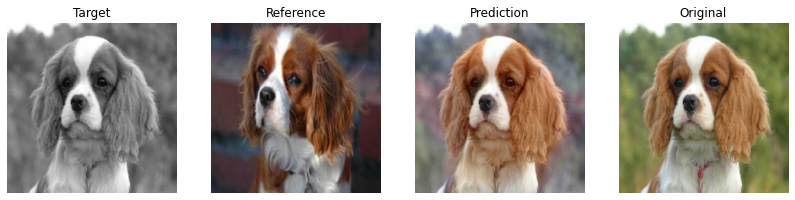

In [7]:
pred = _lab2rgb(pred_t, device)
    
plt.figure(figsize=(14, 6)); 
plt.subplot(1, 4, 1); plt.title("Target"); plt.axis("off"); plt.imshow(tgt.convert("L"), cmap="gray");
plt.subplot(1, 4, 2); plt.title("Reference"); plt.axis("off"); plt.imshow(ref);
plt.subplot(1, 4, 3); plt.title("Prediction"); plt.axis("off"); plt.imshow(pred);
plt.subplot(1, 4, 4); plt.title("Original"); plt.axis("off"); plt.imshow(tgt);